In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('merged_output.csv')

In [3]:
# Convert to datetime
df['CreatedOn'] = pd.to_datetime(df['CreatedOn'])

# Sort by date
df = df.sort_values(['district', 'CreatedOn'])

# Aggregate monthly pest counts
df['year_month'] = df['CreatedOn'].dt.to_period('M')

df_monthly = df.groupby(['district', 'year_month']).agg({
    'pest_count': 'sum',
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()

# Convert period to timestamp
df_monthly['year_month'] = df_monthly['year_month'].dt.to_timestamp()

# Sort again
df_monthly = df_monthly.sort_values(['district', 'year_month'])

df_monthly.head()

,district,year_month,pest_count,latitude,longitude
0,24 PARGANAS (NORTH DISTRICT),2013-04-01,21,22.591967,88.39957
1,24 PARGANAS (NORTH DISTRICT),2013-05-01,24,22.591967,88.39957
2,24 PARGANAS (NORTH DISTRICT),2013-06-01,15,22.591967,88.39957
3,24 PARGANAS (NORTH DISTRICT),2013-07-01,14,22.591967,88.39957
4,24 PARGANAS (NORTH DISTRICT),2013-09-01,22,22.591967,88.39957


In [4]:
from sklearn.neighbors import kneighbors_graph

# Unique districts with coordinates
district_coords = df_monthly[['district', 'latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

# Create adjacency matrix (5 nearest neighbors)
A = kneighbors_graph(
    district_coords[['latitude', 'longitude']],
    n_neighbors=5,
    mode='connectivity',
    include_self=False
)

A = A.toarray()

In [5]:
# Pivot to time x district matrix
pivot_df = df_monthly.pivot(index='year_month', 
                            columns='district', 
                            values='pest_count')

pivot_df = pivot_df.fillna(0)

# Convert to numpy
X = pivot_df.values   # shape = (time_steps, districts)

# Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Add feature dimension
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

print(X_scaled.shape)

(57, 543, 1)


In [6]:
def create_sequences(data, seq_length=12):
    X_seq = []
    y_seq = []

    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(data[i+seq_length])

    return np.array(X_seq), np.array(y_seq)

seq_length = 6
X_seq, y_seq = create_sequences(X_scaled, seq_length)

print(X_seq.shape, y_seq.shape)

(51, 6, 543, 1) (51, 543, 1)


In [7]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse

# Convert adjacency matrix to edge_index
edge_index, _ = dense_to_sparse(torch.tensor(A, dtype=torch.float))

class STGCN(nn.Module):
    def __init__(self, num_nodes, in_channels=1, gcn_hidden=16, lstm_hidden=32):
        super(STGCN, self).__init__()

        self.gcn = GCNConv(in_channels, gcn_hidden)
        self.lstm = nn.LSTM(gcn_hidden, lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

        self.num_nodes = num_nodes

    def forward(self, x):
        # x shape: (batch, seq_len, nodes, features)
        batch_size, seq_len, num_nodes, features = x.shape

        gcn_out_seq = []

        for t in range(seq_len):
            xt = x[:, t, :, :]   # (batch, nodes, features)
            xt = xt.reshape(-1, features)

            gcn_out = self.gcn(xt, edge_index)
            gcn_out = gcn_out.reshape(batch_size, num_nodes, -1)

            gcn_out_seq.append(gcn_out)

        gcn_out_seq = torch.stack(gcn_out_seq, dim=1)

        # Apply LSTM
        gcn_out_seq = gcn_out_seq.reshape(batch_size*num_nodes, seq_len, -1)
        lstm_out, _ = self.lstm(gcn_out_seq)

        out = self.fc(lstm_out[:, -1, :])

        out = out.reshape(batch_size, num_nodes, 1)

        return out

In [8]:
# Chronological split (80% train, 20% test)

train_size = int(0.8 * len(X_seq))

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_test = X_seq[train_size:]
y_test = y_seq[train_size:]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (40, 6, 543, 1)
Test shape: (11, 6, 543, 1)


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).to(device)

In [11]:
model = STGCN(num_nodes=X_seq.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 500

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)

    loss.backward()
    optimizer.step()

    
    print(f"Epoch {epoch}, Train Loss: {loss.item()}")


Epoch 0, Train Loss: 0.07716649770736694
Epoch 1, Train Loss: 0.07494912296533585
Epoch 2, Train Loss: 0.07300540059804916
Epoch 3, Train Loss: 0.07132948935031891
Epoch 4, Train Loss: 0.06991388648748398
Epoch 5, Train Loss: 0.06874895840883255
Epoch 6, Train Loss: 0.06782300770282745
Epoch 7, Train Loss: 0.06712215393781662
Epoch 8, Train Loss: 0.06662984937429428
Epoch 9, Train Loss: 0.06632615625858307
Epoch 10, Train Loss: 0.06618668138980865
Epoch 11, Train Loss: 0.06618167459964752
Epoch 12, Train Loss: 0.06627564877271652
Epoch 13, Train Loss: 0.06642879545688629
Epoch 14, Train Loss: 0.06660082191228867
Epoch 15, Train Loss: 0.06675666570663452
Epoch 16, Train Loss: 0.06687158346176147
Epoch 17, Train Loss: 0.0669330283999443
Epoch 18, Train Loss: 0.06693952530622482
Epoch 19, Train Loss: 0.06689777225255966
Epoch 20, Train Loss: 0.06681928038597107
Epoch 21, Train Loss: 0.06671741604804993
Epoch 22, Train Loss: 0.06660526990890503
Epoch 23, Train Loss: 0.06649413704872131
Epo

In [12]:
model.eval()

with torch.no_grad():
    test_predictions = model(X_test_tensor)

# Move to CPU
test_predictions = test_predictions.cpu().numpy()
y_test_actual = y_test_tensor.cpu().numpy()

In [13]:
test_predictions = test_predictions.reshape(-1)
y_test_actual = y_test_actual.reshape(-1)


In [14]:
# We must reshape back to original format for inverse scaling

num_districts = pivot_df.shape[1]

pred_reshaped = test_predictions.reshape(-1, num_districts)
actual_reshaped = y_test_actual.reshape(-1, num_districts)

pred_inverse = scaler.inverse_transform(pred_reshaped)
actual_inverse = scaler.inverse_transform(actual_reshaped)

# Flatten again
pred_inverse = pred_inverse.flatten()
actual_inverse = actual_inverse.flatten()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(actual_inverse, pred_inverse)
rmse = np.sqrt(mean_squared_error(actual_inverse, pred_inverse))
r2 = r2_score(actual_inverse, pred_inverse)

mape = np.mean(np.abs((actual_inverse - pred_inverse) / 
                      (actual_inverse + 1e-8))) * 100

print("MAE :", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R2  :", r2)


MAE : 18.191458
RMSE: 38.43836
MAPE: 59787372800.0
R2  : 0.21937793493270874


In [20]:
district_mae = []

for i in range(num_districts):
    mae_d = mean_absolute_error(actual_reshaped[:, i],
                                pred_reshaped[:, i])
    district_mae.append(mae_d)

district_results = pd.DataFrame({
    'district': pivot_df.columns,
    'MAE': district_mae
})

district_results.sort_values('MAE')

,district,MAE
97,CHAMPARAN(EAST),0.051268
440,SARAN,0.054990
270,KHAGARIA,0.069446
473,SONEPAT,0.071765
22,ANANTPUR,0.078604
...,...,...
336,MORADABAD,0.373882
478,SOUTH WEST,0.390276
257,KARAULI,0.403887
218,JALAUN,0.409200


In [17]:
# reshape back
num_districts = pivot_df.shape[1]

pred_full = pred_inverse.reshape(-1, num_districts)
actual_full = actual_inverse.reshape(-1, num_districts)

# Sum across all districts
total_pred = pred_full.sum(axis=1)
total_actual = actual_full.sum(axis=1)


In [18]:
# Original total pest counts
total_series = pivot_df.sum(axis=1)

# Remove first seq_length months
total_series_seq = total_series[seq_length:]

train_total = total_series_seq[:train_size]
test_total  = total_series_seq[train_size:]

# Dates
dates_seq = pivot_df.index[seq_length:]
train_dates = dates_seq[:train_size]
test_dates  = dates_seq[train_size:]



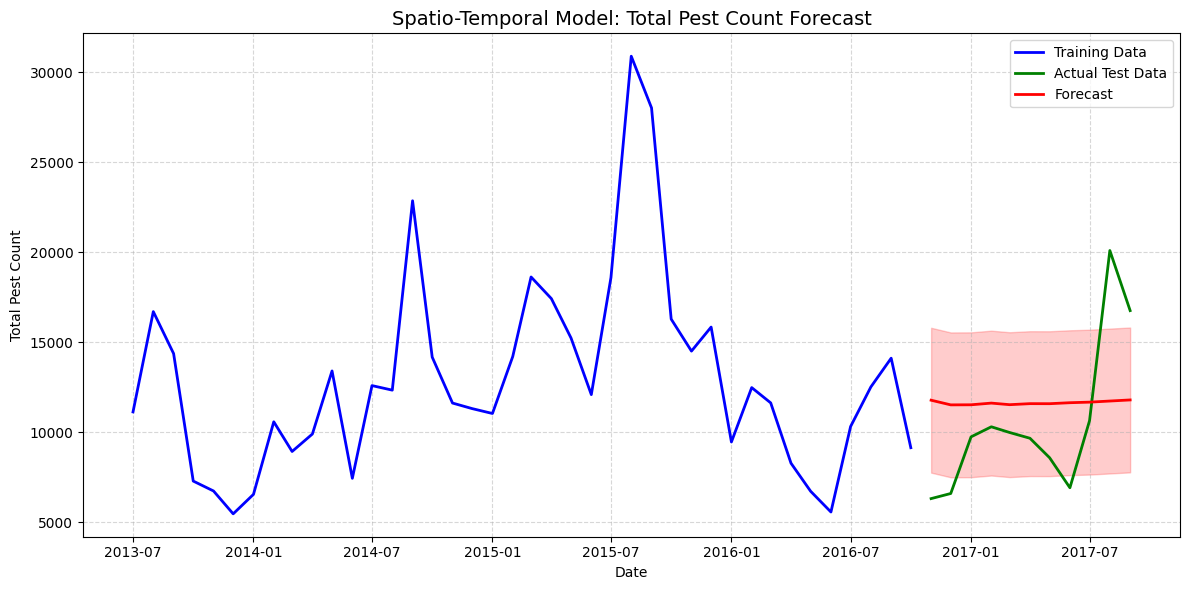

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,6))

# Training data
plt.plot(train_dates,
         train_total,
         label='Training Data',
         color='blue',
         linewidth=2)

# Actual test
plt.plot(test_dates,
         total_actual,
         label='Actual Test Data',
         color='green',
         linewidth=2)

# Predicted test
plt.plot(test_dates,
         total_pred,
         label='Forecast',
         color='red',
         linewidth=2)

# Confidence band (approximate)
error_std = np.std(total_actual - total_pred)

plt.fill_between(test_dates,
                 total_pred - error_std,
                 total_pred + error_std,
                 color='red',
                 alpha=0.2)

plt.title("Spatio-Temporal Model: Total Pest Count Forecast", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Pest Count")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()